# Week 2 — Multiple Linear Regression

In this week, the goal is to extend simple linear regression to  **a multiple linear regression** setting, where several predictors jointly explain the target variable.

**The focus is not on optimizing model performance**, but on understanding how coefficients should be interpreted when multiple variables are included, and how multicollinearity affects coefficient stability and interpretability. Real-world datasets often contain correlated predictors, and learning how to diagnose and reason about this issue is a key objective.

In this notebook, a multiple linear regression model is fitted to the California Housing dataset. After fitting the model, coefficient estimates are examined to understand the conditional effect of each feature while holding others constant. **Variance Inflation Factor (VIF)** is then used to detect multicollinearity among predictors and assess which variables contain overlapping information.

Finally, the model is evaluated using a train–test split to distinguish between interpretability issues caused by multicollinearity and predictive performance on unseen data. This separation between explanation and prediction is central to understanding multiple linear regression.


In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# In this part:
Move from one predictor to several predictors and learn how to:
* Interpret coefficients when variables interact
* Handle categorical data
* Detect multicollinearity
* Evaluate generalization with train–test split

In [325]:
df = pd.read_csv('housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [329]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [331]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [333]:
df.duplicated().sum()

0

In [335]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

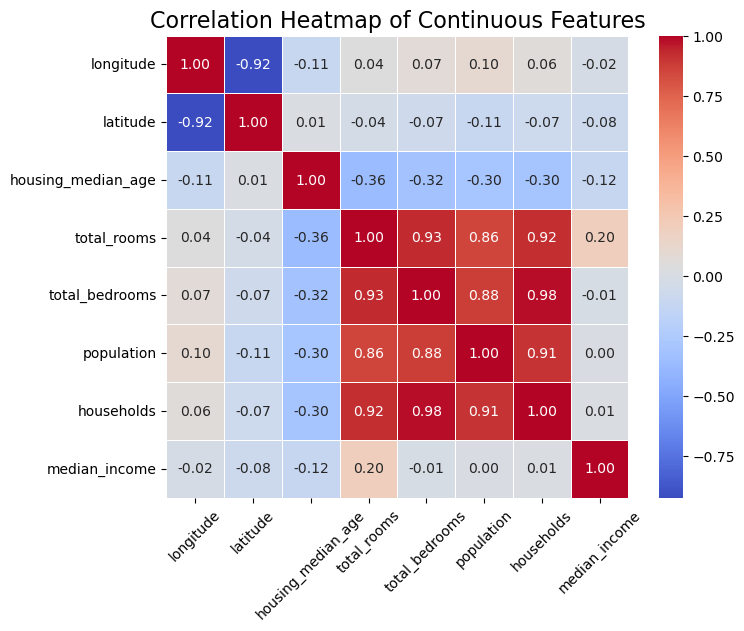

In [337]:
#correlation matrix
con_fea = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

df_con = df[con_fea]

corr_matrix = df_con.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, 
            annot=True,        # Show correlation values
            fmt=".2f",         # 2 decimal places
            cmap='coolwarm',   # Color palette
            cbar=True,         # Show color bar
            square=True,       # Make squares
            linewidths=0.5)    # Lines between cells

plt.title('Correlation Heatmap of Continuous Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Severe multicollinearity (problematic)
* These variables are almost duplicates in information:
1. total_rooms ↔ total_bedrooms → 0.93
2. total_bedrooms ↔ households → 0.98
3. population ↔ households → 0.91
4. total_rooms ↔ households → 0.92
5. population ↔ total_rooms → 0.86

In [340]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']


In [342]:
df.drop(columns = ['total_rooms', 'households', 'total_bedrooms','population'], inplace = True)
df

,longitude,latitude,housing_median_age,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1.5603,78100.0,INLAND,5.045455,0.224625,2.560606
20636,-121.21,39.49,18.0,2.5568,77100.0,INLAND,6.114035,0.215208,3.122807
20637,-121.22,39.43,17.0,1.7000,92300.0,INLAND,5.205543,0.215173,2.325635
20638,-121.32,39.43,18.0,1.8672,84700.0,INLAND,5.329513,0.219892,2.123209


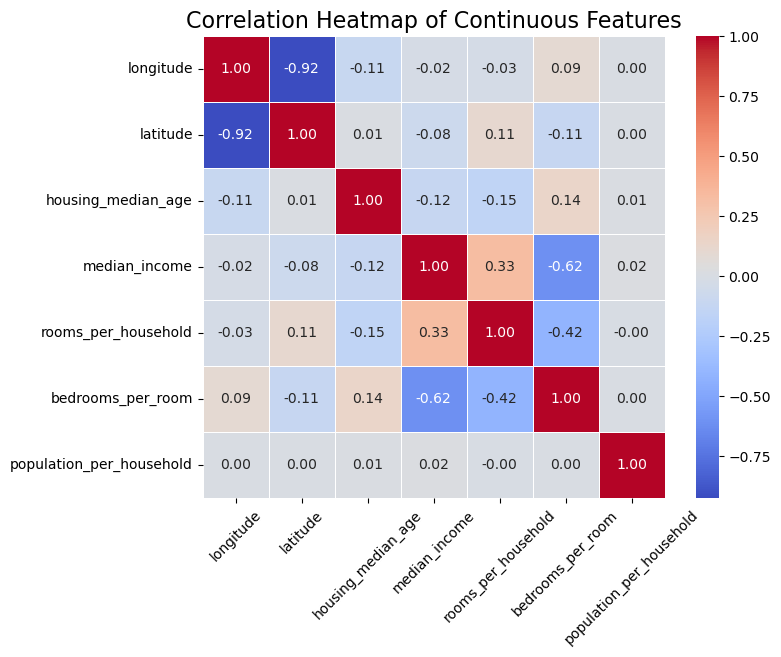

In [344]:
#correlation matrix
con_fea = ['longitude', 'latitude', 'housing_median_age', 'median_income' ,'rooms_per_household',
           'bedrooms_per_room','population_per_household']

df_con = df[con_fea]

corr_matrix = df_con.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, 
            annot=True,        # Show correlation values
            fmt=".2f",         # 2 decimal places
            cmap='coolwarm',   # Color palette
            cbar=True,         # Show color bar
            square=True,       # Make squares
            linewidths=0.5)    # Lines between cells

plt.title('Correlation Heatmap of Continuous Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 1. Define feature groups

In [347]:
# Target
target = 'median_house_value'

# Continuous numerical features
num_features = [
    'longitude',
    'latitude',
    'housing_median_age',
    'median_income',
    'rooms_per_household',
    'bedrooms_per_room',
    'population_per_household'
]

# Categorical features
cat_features = ['ocean_proximity']


In [349]:
df[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
housing_median_age,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
median_income,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
rooms_per_household,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
bedrooms_per_room,20433.0,0.213039,0.057983,0.100000,0.175427,0.203162,0.239821,1.000000
population_per_household,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333


In [351]:
df[cat_features].nunique()

ocean_proximity    5
dtype: int64

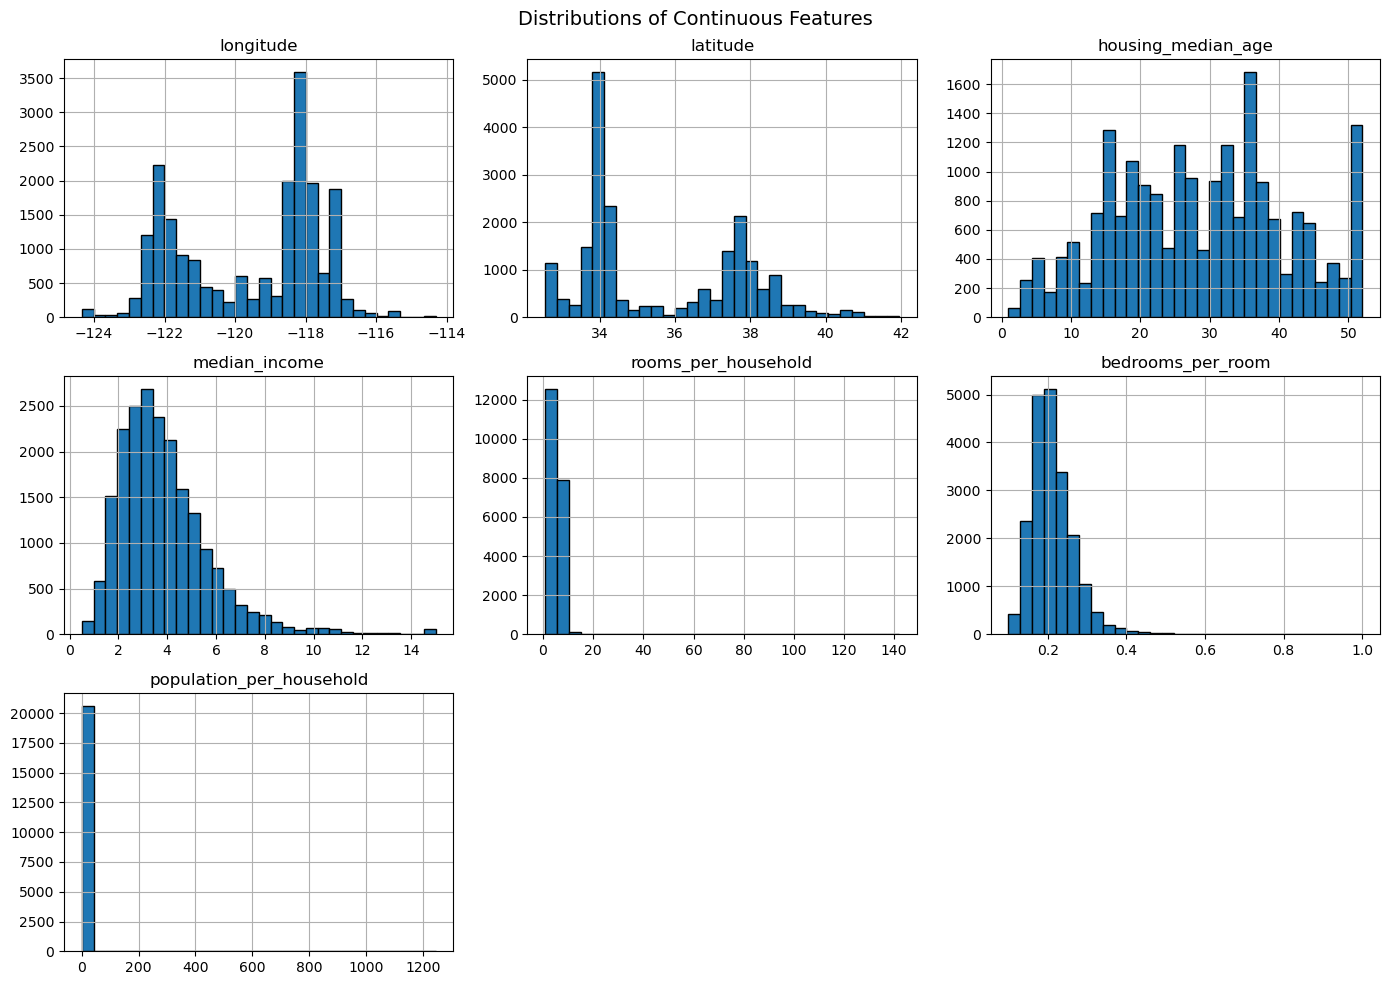

In [353]:
df[num_features].hist(
    bins=30,
    figsize=(14, 10),
    edgecolor='black'
)
plt.suptitle('Distributions of Continuous Features', fontsize=14)
plt.tight_layout()

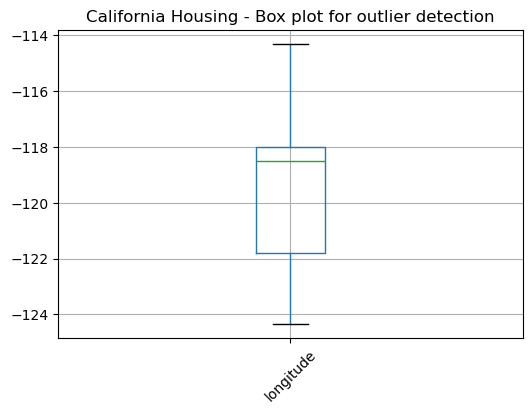

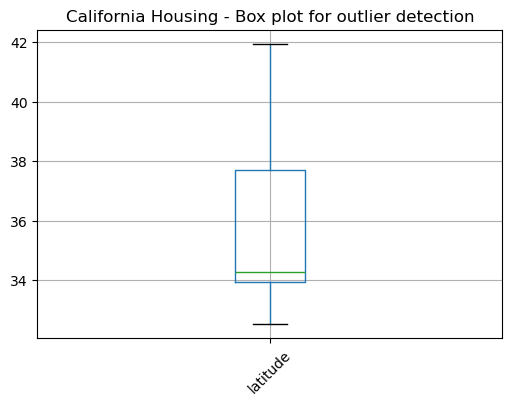

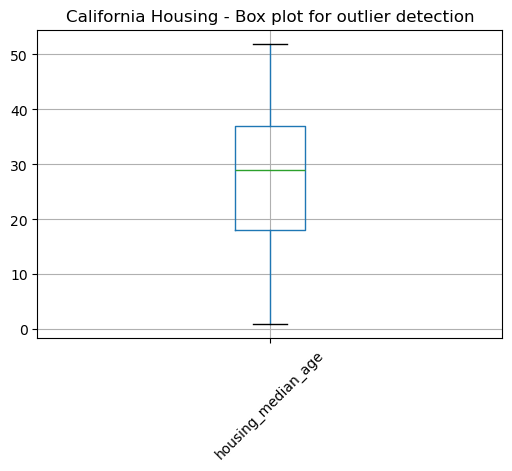

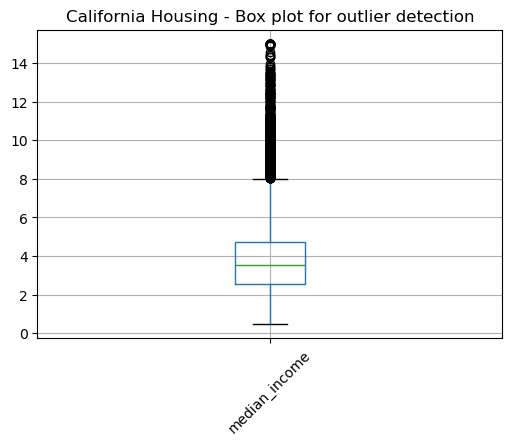

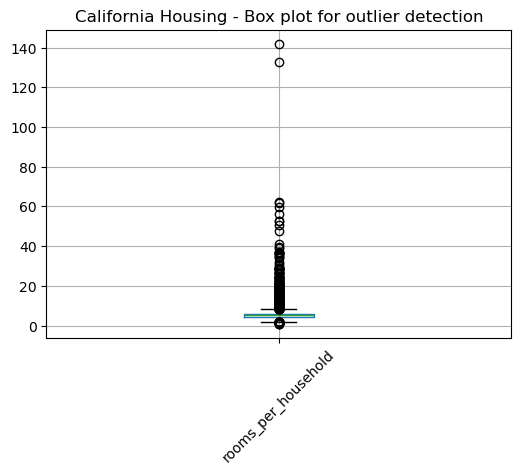

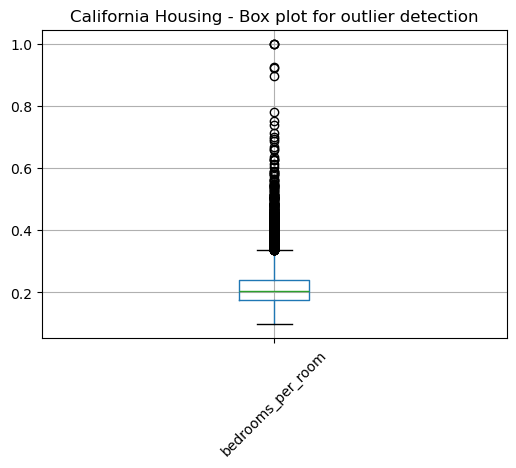

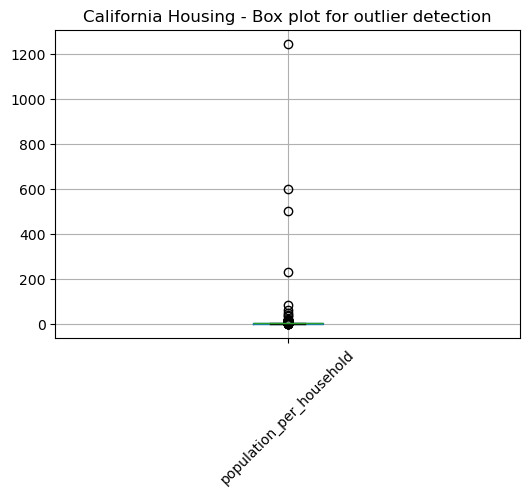

In [355]:
#Outliers detection - Boxplot
for col in num_continuous:

     plt.figure(figsize = (6,4))
     df[[col]].boxplot()
     plt.title("California Housing - Box plot for outlier detection")
     plt.xticks(rotation = 45)
     plt.show()

In [357]:
float_col = ['longitude', 'latitude', 'housing_median_age', 'rooms_per_household',
             'bedrooms_per_room', 'population_per_household' , 'median_income']

    
   
lst = []

for i in float_col:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    
    if ((df[i]<lower)|(df[i]>upper)).any():
        lst.append(i)
lst

['rooms_per_household',
 'bedrooms_per_room',
 'population_per_household',
 'median_income']

In [359]:
outliers = {}

for i in float_col:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    
    outliers[i] = df[(df[i]< lower) | (df[i] > upper)]

outliers

{'longitude': Empty DataFrame
 Columns: [longitude, latitude, housing_median_age, median_income, median_house_value, ocean_proximity, rooms_per_household, bedrooms_per_room, population_per_household]
 Index: [],
 'latitude': Empty DataFrame
 Columns: [longitude, latitude, housing_median_age, median_income, median_house_value, ocean_proximity, rooms_per_household, bedrooms_per_room, population_per_household]
 Index: [],
 'housing_median_age': Empty DataFrame
 Columns: [longitude, latitude, housing_median_age, median_income, median_house_value, ocean_proximity, rooms_per_household, bedrooms_per_room, population_per_household]
 Index: [],
 'rooms_per_household':        longitude  latitude  housing_median_age  median_income  \
 73       -122.29     37.81                46.0         0.4999   
 155      -122.23     37.81                52.0         8.8793   
 511      -122.22     37.82                42.0        13.4990   
 512      -122.23     37.82                52.0        12.2138   
 51

In [361]:
for i in float_col:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    
    median_val = df[i].median()

    # Replace outliers
    df[i] = df[i].apply(
        lambda x: median_val if (x < lower or x > upper) else x
    )


In [363]:
df['bedrooms_per_room'] = df['bedrooms_per_room'].fillna(df['bedrooms_per_room'].median())

In [365]:
df.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
median_income               0
median_house_value          0
ocean_proximity             0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
dtype: int64

In [367]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

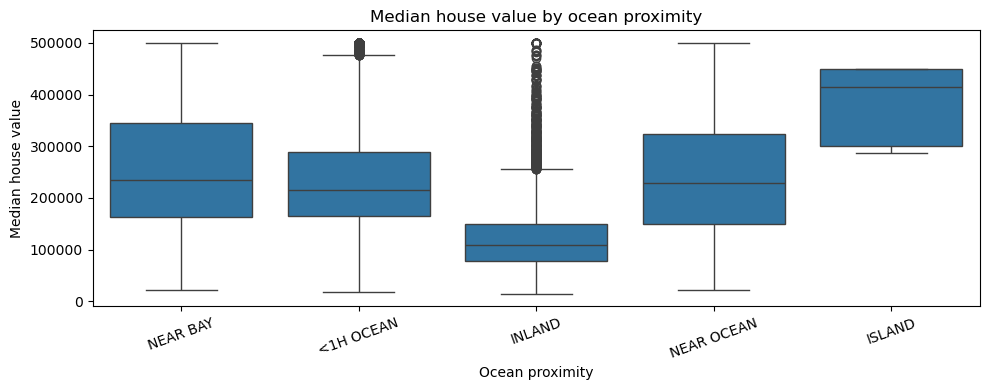

In [369]:


plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x="ocean_proximity", y="median_house_value")
plt.title("Median house value by ocean proximity")
plt.xlabel("Ocean proximity")
plt.ylabel("Median house value")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


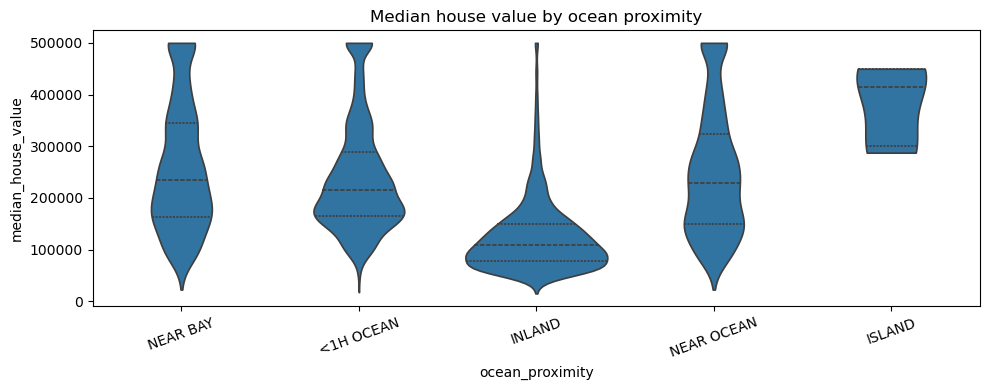

In [371]:
plt.figure(figsize=(10, 4))
sns.violinplot(data=df, x="ocean_proximity", y="median_house_value", inner="quartile", cut=0)
plt.title("Median house value by ocean proximity")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


# Categories have distinct distributions
+ INLAND → clearly lowest median house value
+ <1H OCEAN / NEAR BAY / NEAR OCEAN → higher, overlapping but distinct
+ ISLAND → very high median (small group, extreme)
+ This means:
ocean_proximity does affect the target

Exploratory analysis reveals substantial differences in median house values across ocean proximity categories, with inland districts exhibiting markedly lower values. As ocean_proximity is a nominal categorical variable with no inherent ordering, it is encoded using one-hot encoding, with INLAND serving as the reference category.

In [375]:
df["ocean_proximity"] = pd.Categorical(
    df["ocean_proximity"],
    categories=["INLAND", "NEAR BAY", "NEAR OCEAN", "ISLAND", "<1H OCEAN"], 
    ordered=True
)

df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True, dtype=int)


In [377]:
df

,longitude,latitude,housing_median_age,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND,ocean_proximity_<1H OCEAN
0,-122.23,37.88,41.0,3.5348,452600.0,6.984127,0.146591,2.555556,1,0,0,0
1,-122.22,37.86,21.0,3.5348,358500.0,6.238137,0.155797,2.109842,1,0,0,0
2,-122.24,37.85,52.0,7.2574,352100.0,8.288136,0.129516,2.802260,1,0,0,0
3,-122.25,37.85,52.0,5.6431,341300.0,5.817352,0.184458,2.547945,1,0,0,0
4,-122.25,37.85,52.0,3.8462,342200.0,6.281853,0.172096,2.181467,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1.5603,78100.0,5.045455,0.224625,2.560606,0,0,0,0
20636,-121.21,39.49,18.0,2.5568,77100.0,6.114035,0.215208,3.122807,0,0,0,0
20637,-121.22,39.43,17.0,1.7000,92300.0,5.205543,0.215173,2.325635,0,0,0,0
20638,-121.32,39.43,18.0,1.8672,84700.0,5.329513,0.219892,2.123209,0,0,0,0


In [237]:
#1) fit Multiple linear Regression

In [239]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [241]:
# define target and other varibles 
y = df['median_house_value']
X = df.drop(columns = ['median_house_value'])

# 2) Fit on full data (for coefficient inspection only)
model_full = LinearRegression()
model_full.fit(X, y)

print("Intercept:", model_full.intercept_)


Intercept: -2641170.203794566


In [243]:
#2) Interpret Coefficients 
coef_df = pd.DataFrame(
    {
        "feature" : X.columns,
        "coef" : model_full.coef_
    }).sort_values("coef", ascending=False)
coef_df

,feature,coef
8,ocean_proximity_ISLAND,113589.801552
3,median_income,24837.549540
4,rooms_per_household,14164.640447
2,housing_median_age,780.364437
9,ocean_proximity_NEAR BAY,-7731.944055
10,ocean_proximity_NEAR OCEAN,-8068.466699
0,longitude,-34601.605880
1,latitude,-35649.445921
6,population_per_household,-49427.031752
7,ocean_proximity_INLAND,-54651.612924


1. Change in median house value when that feature increases by 1 unit, holding all other features constant.

## Coefficient Interpretation (Multiple Linear Regression)

Each coefficient represents the expected change in `median_house_value` for a one-unit increase in the corresponding feature, holding all other variables constant.

### Key Numerical Features
- **median_income (+24,838)**  
  Median income has a strong positive effect on house prices. Higher-income areas are associated with substantially higher house values, making this the most influential economic variable in the model.

- **rooms_per_household (+14,165)**  
  An increase in average rooms per household is associated with higher house values, reflecting the premium placed on larger living spaces.

- **population_per_household (−49,427)**  
  Higher population density within households negatively affects house values, indicating that overcrowding reduces housing desirability.

- **bedrooms_per_room (−225,468)**  
  A higher proportion of bedrooms relative to total rooms is strongly negatively associated with house value. This likely captures lower housing quality or inefficient layouts. The large magnitude is due to the variable’s small scale and should be interpreted cautiously.

- **housing_median_age (+780)**  
  Older houses show a mild positive association with price, possibly reflecting established neighborhoods or desirable locations.

### Spatial Features
- **longitude (−34,602)** and **latitude (−35,649)**  
  These coefficients capture geographic effects. Moving inland or northward is associated with lower house values. These variables should be interpreted jointly, as they reflect spatial clustering rather than isolated effects.

### Categorical Features: Ocean Proximity
(Coefficients are relative to the omitted reference category.)

- **ISLAND (+113,590)**  
  Houses located on islands are significantly more expensive, though this estimate may be unstable due to the small number of observations.

- **INLAND (−54,652)**  
  Inland properties are substantially cheaper than coastal reference locations.

- **NEAR BAY (−7,732)** and **NEAR OCEAN (−8,068)**  
  These locations show smaller negative differences relative to the reference category.

### Summary
The model indicates that **income, location, and housing structure** are the primary drivers of house values.  
Coefficient signs are economically intuitive, while magnitudes should be interpreted carefully due to differences in variable scales and remaining multicollinearity.


In [247]:
# Check Multicollinearity (VIF)

+ VIF tells whether a feature is highly explained by the other features.
+ Rule of thumb:
+ VIF ≈ 1 → no multicollinearity
+ VIF > 5 → concerning
+ VIF > 10 → serious (often remove/transform/combine variables)


In [250]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X.copy()

vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df

,feature,VIF
0,longitude,1394.652373
1,latitude,878.257700
5,bedrooms_per_room,69.293873
4,rooms_per_household,65.497447
6,population_per_household,24.229817
3,median_income,15.407977
2,housing_median_age,7.325840
7,ocean_proximity_INLAND,2.750294
9,ocean_proximity_NEAR BAY,1.674507
10,ocean_proximity_NEAR OCEAN,1.328432


## Multicollinearity Analysis (VIF)

Variance Inflation Factor (VIF) measures how strongly a feature is linearly explained by the other predictors.  
High VIF values indicate multicollinearity, which leads to unstable coefficient estimates and unreliable interpretation.

### Observations

- **longitude (VIF ≈ 1395)** and **latitude (VIF ≈ 878)**  
  Extremely high VIF values indicate severe multicollinearity. These variables jointly encode geographic location and are highly correlated with each other and with regional housing patterns. Their coefficients should not be interpreted individually.

- **bedrooms_per_room (VIF ≈ 69)** and **rooms_per_household (VIF ≈ 65)**  
  High VIF values suggest redundancy among housing structure variables. Although these ratio features reduce multicollinearity compared to raw counts, they still capture overlapping information related to housing size and layout.

- **population_per_household (VIF ≈ 24)**  
  Indicates moderate to high multicollinearity with other household-related variables, reflecting shared information about crowding and housing density.

- **median_income (VIF ≈ 15)**  
  Shows moderate multicollinearity, likely due to correlation with location and housing quality variables. The coefficient remains economically meaningful but should be interpreted cautiously.

- **housing_median_age (VIF ≈ 7)**  
  Mild multicollinearity, generally acceptable for interpretation.

- **Ocean proximity dummy variables (VIF < 3)**  
  Low VIF values indicate no multicollinearity issues. These coefficients are stable and interpretable relative to the reference category.

### Interpretation

The model exhibits **severe multicollinearity**, primarily driven by spatial variables (longitude, latitude) and housing structure ratios. While this does not significantly harm predictive performance, it reduces the reliability of individual coefficient estimates and their magnitudes.

### Recommended Actions

- Retain all variables for **prediction-focused analysis**.
- Avoid interpreting coefficients of longitude and latitude individually; treat them as joint spatial controls.
- For interpretation-focused models:
  - Consider removing either latitude or longitude, or
  - Replace them with regional indicators or clustering variables.
- Prepare for regularization (Ridge/Lasso) in later stages to stabilize coefficient estimates.

### Conclusion

Multicollinearity is expected in real-world housing data. In this model, it primarily affects spatial and size-related variables. Coefficient signs remain informative, but magnitudes should be interpreted with caution.


In [401]:
## Model Evaluation (Train–Test Split)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train, r2_test, rmse_train, rmse_test


(0.551098012452726, 0.5427052606087186, 77464.9853922509, 77410.79590087339)

Despite severe multicollinearity among predictors, the model shows similar performance on training and test sets. 
This confirms that multicollinearity affects coefficient stability and interpretability but does not significantly reduce predictive accuracy.


In [404]:
n = X_train.shape[0]
p = X_train.shape[1]

adj_r2_test = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)
adj_r2_test


0.5424003974491244

Adjusted R² accounts for model complexity and is therefore more informative when predictors are correlated.


Removing a highly collinear variable has little impact on test performance, confirming redundancy among spatial predictors.


In [408]:
X_reduced = X.drop(columns=["longitude"])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

model_r = LinearRegression()
model_r.fit(Xr_train, yr_train)

r2_test_reduced = r2_score(yr_test, model_r.predict(Xr_test))
r2_test_reduced


0.5230548342708419

### Explanation vs. Prediction in Multiple Linear Regression

Multiple linear regression serves two related but distinct purposes: explanation and prediction.

**Explanation** focuses on understanding the relationship between the dependent variable and each predictor. In this context, the primary interest lies in the estimated coefficients and their interpretation. Each coefficient represents the marginal effect of a predictor while holding all other variables constant. However, when predictors are highly correlated, multicollinearity inflates coefficient variance, making individual estimates unstable and harder to interpret reliably.

**Prediction**, on the other hand, focuses on how well the model estimates the outcome for new, unseen observations. Predictive performance depends on the combined information contained in all predictors rather than on the stability of individual coefficients. As a result, a model can still produce accurate predictions even when multicollinearity is present, because correlated predictors jointly capture the same underlying signal.

In this analysis, multicollinearity is explicitly diagnosed and discussed to highlight its impact on interpretability. The model is then evaluated using a train–test split to show that, despite unstable coefficients, predictive performance remains largely unaffected. This distinction clarifies why high VIF values are a concern for explanation but not necessarily for prediction.
